In [1]:
import pandas as pd
import numpy as np
from scipy.stats import skew, kurtosis
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import shapiro, mannwhitneyu

from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score


In [2]:
symbol = "BNBUSDT"
## Window
input_path = r"C:\Users\phamhoa\Downloads\thesis\data\Binance\agg\500\VPIN"
df = pd.read_csv(rf"{input_path}\{symbol}.csv")

## MacOS
# input_path = "/Users/hoapham/Documents/Learning/thesis/data/Binance/agg/500/VPIN"
# df = pd.read_csv(f"{input_path}/{symbol}.csv")

try:
    df = df.drop(columns=["Unnamed: 0"])
except:
    pass
df['Time'] = pd.to_datetime(df['Time'])

In [3]:
df.tail()

,Time,Buy,Sell,Price,BidPrice,AskPrice,Volume,VPIN,CDF
632,2025-09-06 03:44:24+00:00,2044.705558,1311.294442,858.377442,858.444184,858.273370,3356.0,0.153843,0.801020
633,2025-09-06 04:04:29+00:00,1595.687000,1760.313000,859.023810,859.150403,858.909056,3356.0,0.152954,0.790816
634,2025-09-06 04:31:45+00:00,2023.063992,1332.936008,858.862635,858.915534,858.782347,3356.0,0.153817,0.799320
635,2025-09-06 04:49:39+00:00,1810.571153,1545.428847,857.136780,856.992857,857.305396,3356.0,0.149545,0.755102
636,2025-09-06 05:44:22+00:00,1440.601345,1915.398655,857.654130,857.670795,857.641596,3356.0,0.147919,0.727891


# PHÂN TÍCH ĐƠN BIẾN VPIN

### Thống kê mô tả của VPIN

In [5]:
pd.DataFrame(df['VPIN'].describe()).T

,count,mean,std,min,25%,50%,75%,max
VPIN,588.0,0.14453,0.020364,0.111539,0.133056,0.140671,0.148856,0.214568


- Mẫu gồm 588 quan sát, khá đủ để phân tích thống kê.

- Giá trị trung bình ~0.1445 với độ lệch chuẩn ~0.0204, tức phân phối VPIN dao động nhẹ quanh mức trung bình, không quá phân tán.

- Khoảng biến thiên: từ 0.1115 (min) đến 0.2146 (max) → độ chênh lệch không quá lớn, cho thấy VPIN nằm trong một biên độ tương đối hẹp.

- Phân vị 25% (0.1331), 50% (0.1407), 75% (0.1489) khá sát nhau → dữ liệu tập trung mạnh quanh median, ít cực đoan.

- Có một vài giá trị cao (max 0.2146) xa hơn mức trung bình nhiều, gợi ý khả năng tồn tại outlier hoặc giai đoạn thị trường biến động mạnh.

### Biểu đồ phân bố của VPIN

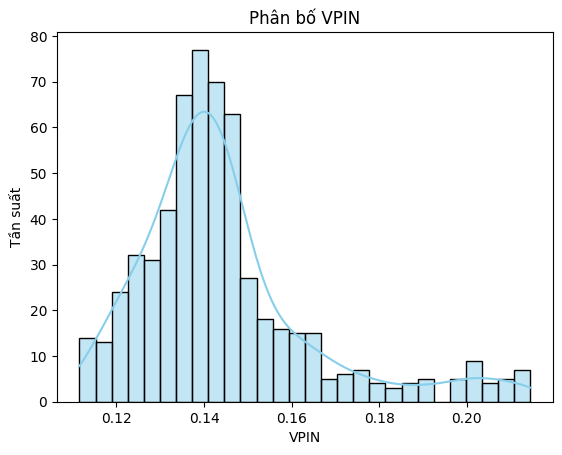

In [6]:

sns.histplot(df['VPIN'], kde=True, color='skyblue')
plt.title('Phân bố VPIN')
plt.xlabel('VPIN')
plt.ylabel('Tần suất')
plt.show()


- Biểu đồ phân bố VPIN cho thấy:

    - Dữ liệu tập trung chủ yếu quanh vùng 0.13 – 0.15, với đỉnh tần suất cao nhất gần 0.14, đúng với median và mean trong bảng thống kê trước.

    - Phân phối có đuôi phải kéo dài (right-skewed), tức tồn tại nhiều giá trị cao bất thường (trên 0.18–0.20). Đây có thể là tín hiệu của những giai đoạn thị trường có dòng lệnh mất cân đối.

    - Phần lớn quan sát nằm trong biên hẹp, cho thấy VPIN thường ổn định, nhưng các đỉnh nhỏ ở vùng 0.20+ phản ánh những trường hợp ngoại lai hoặc trạng thái căng thẳng.

    - Đường mật độ mượt (KDE) cũng cho thấy một phân phối lệch phải nhẹ thay vì chuẩn đối xứng.

### Vẽ biểu đồ hộp - Boxplot của VPIN

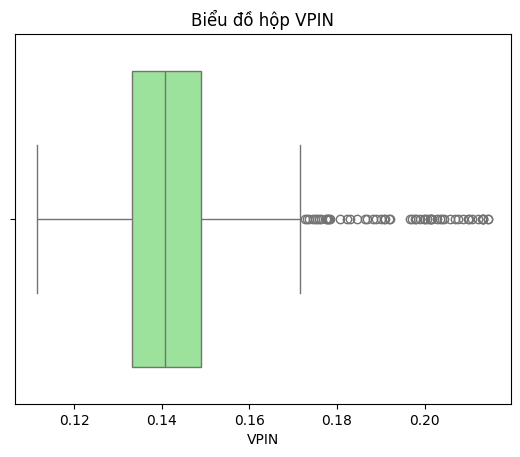

In [7]:
sns.boxplot(x=df['VPIN'], color='lightgreen')
plt.title('Biểu đồ hộp VPIN')
plt.xlabel('VPIN')
plt.show()

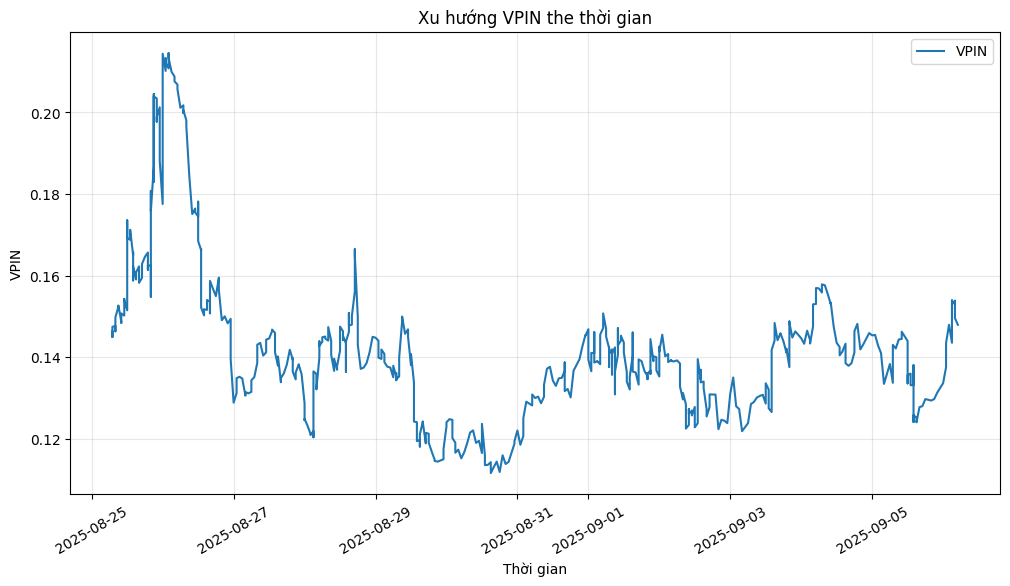

In [8]:
def plot_vpin(buckets, col):
    plt.figure(figsize=(12,6))
    plt.plot(buckets["Time"].dt.floor('h'), buckets[col], label=f'{col}', linewidth=1.5)
    plt.title(f"Xu hướng {col} the thời gian")
    plt.xlabel("Thời gian")
    plt.ylabel(col)
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.xticks(rotation=30)
    plt.show()
plot_vpin(df, "VPIN")


## Tính toán các Biến mục tiêu

In [9]:
# Cửa sổ
window = 50

### 1. Tính Dấu của sự thay đổi Bid-Ask Spread
- Trong bài báo đang tính dấu của sự thay đổi thông qua ước lượng  Corwin-Schultz, tuy nhiên bộ dữ liệu từ Binance cung cấp có thể tính toán được bid-ask rồi nên sẽ tính trực tiếp từ bộ dữ liệu 

In [10]:
df['BidAskSpread'] = df['AskPrice'] - df['BidPrice']
df['SpreadChangeSign'] = np.sign(df['BidAskSpread'].diff())


### 2. Tính dấu của biến động giá (Volatility) - Rolling Standard Deviation

In [11]:
### Tính lợi suất (Returns) từ giá trung bình
df['Returns'] = df['Price'].pct_change()
# Tính độ lệch chuẩn cuộn (Realized Volatility) và dấu hiệu thay đổi
df['RealizedVolatility'] = df['Returns'].rolling(window=window).std()
df['RealizedVolatilitySign'] = np.sign(df['RealizedVolatility'].diff())

### 3. Tính dấu của sự thay đổi trong thống kê Jarque-Bera của lợi suất thực tế


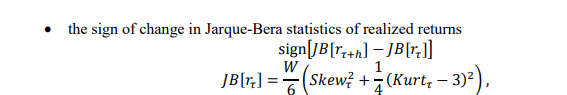

In [12]:
### Tính Skewness và Kurtosis
df['Skewness'] = df['Returns'].rolling(window=window).apply(skew)
df['Kurtosis'] = df['Returns'].rolling(window=window).apply(kurtosis)


In [13]:
def jarque_bera_statistic(skewness, kurtosis, window):
    # Tính Jarque-Bera Statistic theo công thức
    return (window / 6) * (skewness**2 + ((kurtosis - 3)**2) / 4)

In [14]:
df['JB_rolling'] = df.apply(lambda row: jarque_bera_statistic(
    row['Skewness'],
    row['Kurtosis'],
    window
)
    if not np.isnan(row['Skewness']) else np.nan, axis=1)

In [15]:
# Tính dấu của sự thay đổi trong thống kê Jarque-Bera
df['JB_ChangeSign'] = np.sign(df['JB_rolling'].diff())

### 4. Tính Dấu sự thay đổi trong tự tương quan bậc nhất của lợi suất thực tế

In [16]:
df['AR'] = df['Returns'].rolling(window=window).apply(lambda x: x.autocorr(lag=1), raw=False)
df['AR_ChangeSign'] = np.sign(df['AR'].diff())


### 5. Tính dấu của thay đổi trong độ lệch (skewness) tuyệt đối của lợi suất thực tế

In [17]:
df['SkewnessSign'] = np.sign(df['Skewness'].diff())

### 6. Tính dấu của thay đổi trong trong độ nhọn (kurtosis)  của lợi suất thực tế

In [18]:
df['KurtosisSign'] = np.sign(df['Kurtosis'].diff())

# Phân tích mối quan hệ giữa VPIN và các biến mục tiêu

In [19]:
# List các biến mục tiêu
target_cols = [
    'SpreadChangeSign',
    'RealizedVolatilitySign',
    'JB_ChangeSign',
    'AR_ChangeSign',
    'SkewnessSign',
    'KurtosisSign'

]

In [20]:
# Loại bỏ các dữ liệu Nan do việc tính toán các chỉ số thống kê cuộn
df = df.dropna(subset=target_cols + ['VPIN'])

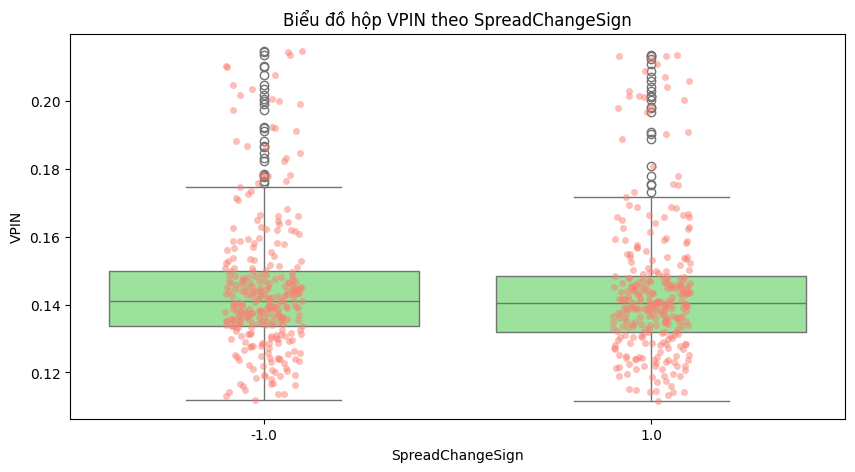

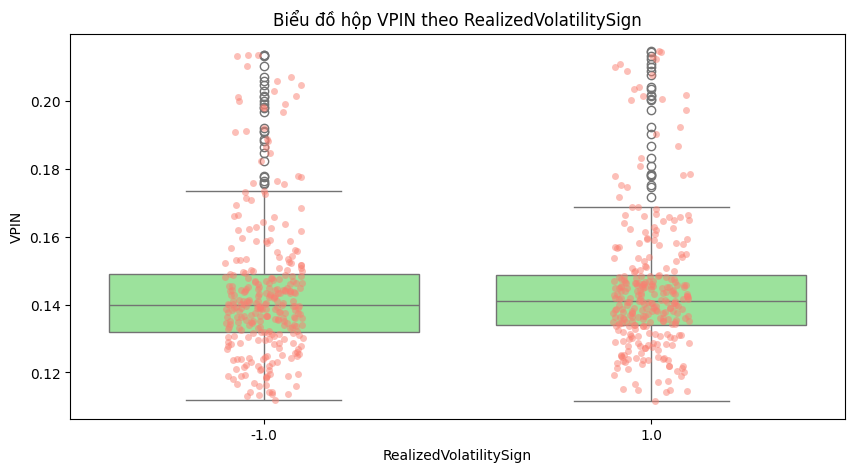

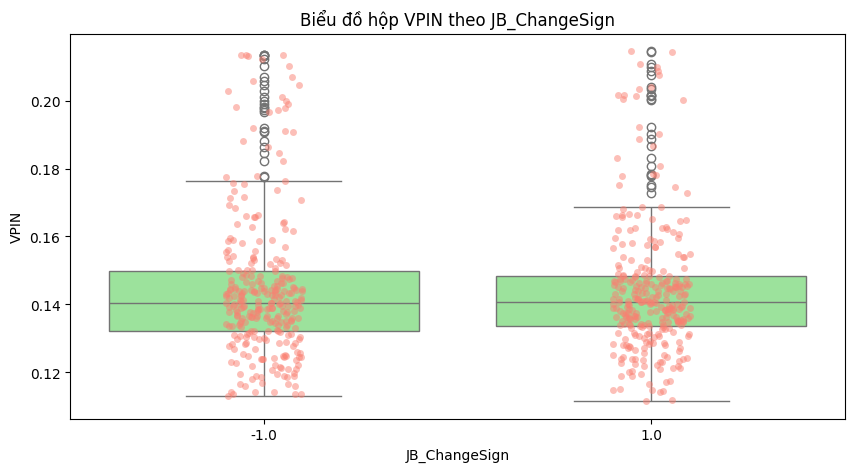

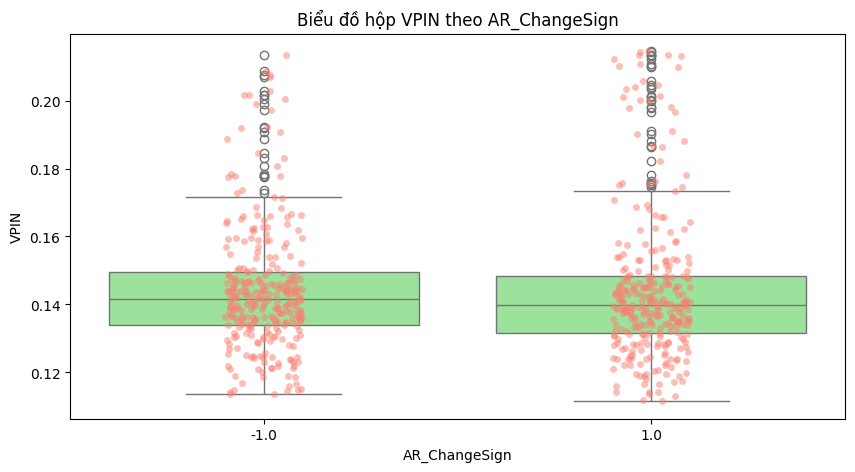

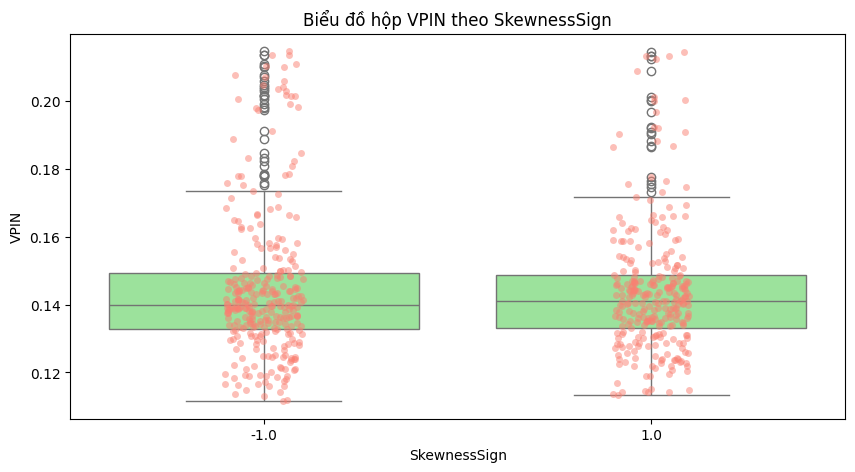

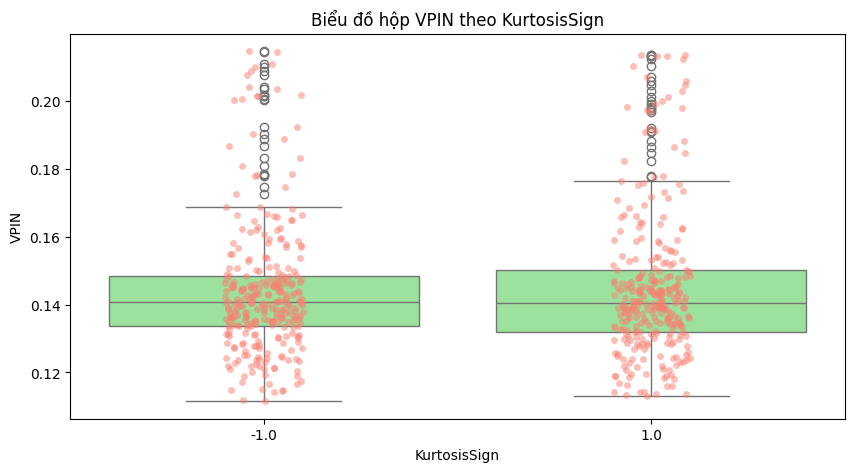

In [21]:
for col in target_cols:
    plt.figure(figsize=(10, 5))
    sns.boxplot(x=col, y='VPIN', data=df, color='lightgreen')
    sns.stripplot(x=col, y='VPIN', data=df, color='salmon', alpha=0.5, jitter=True)
    plt.title(f'Biểu đồ hộp VPIN theo {col}')
    plt.show()

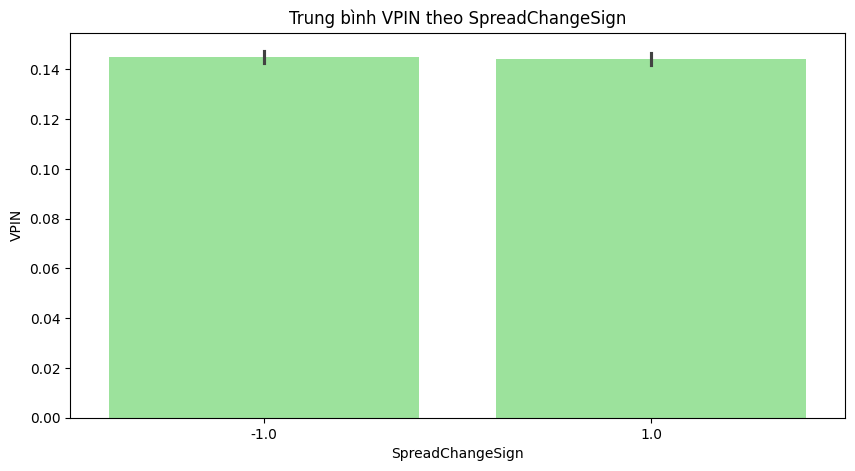

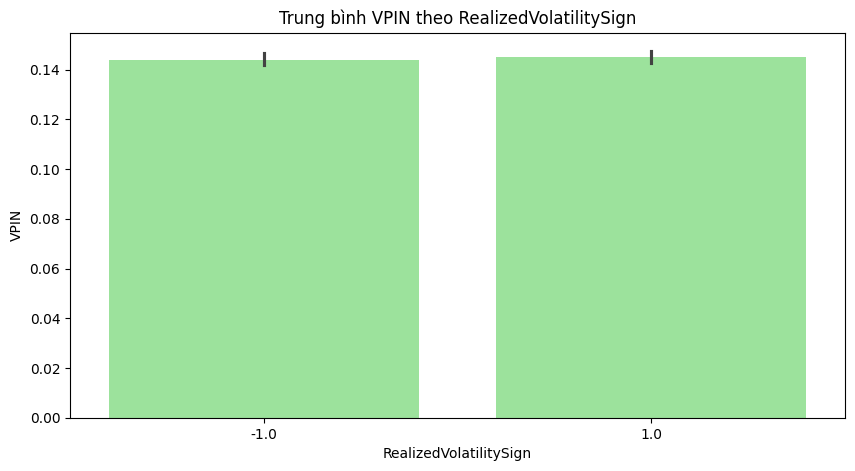

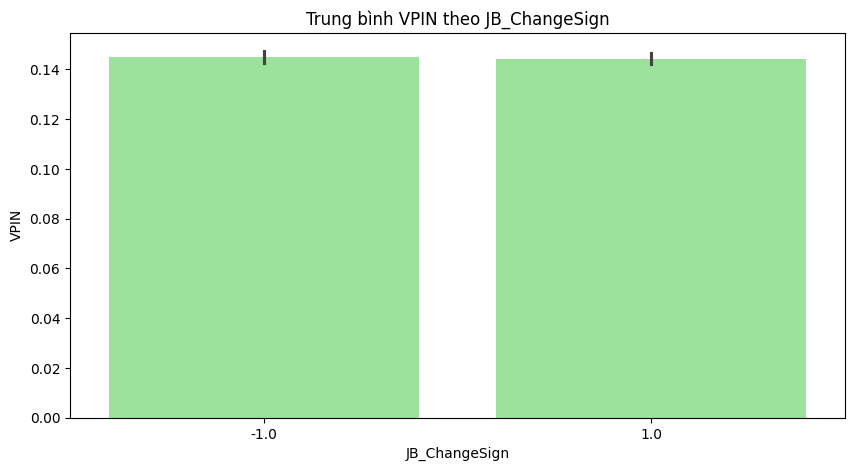

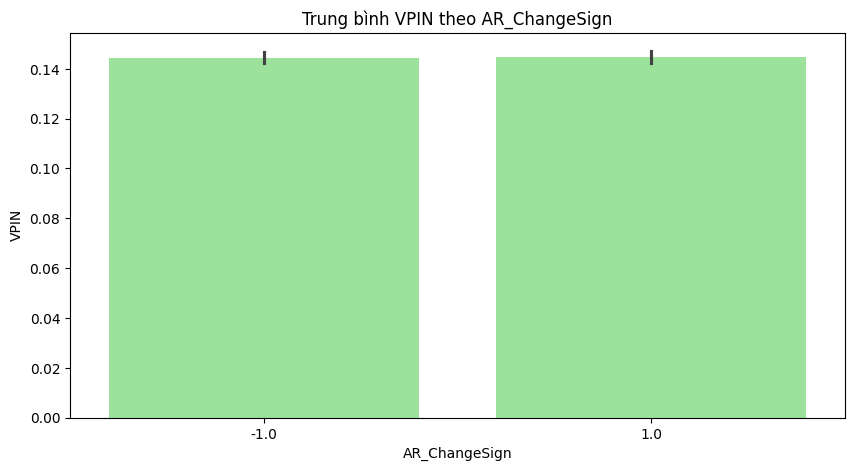

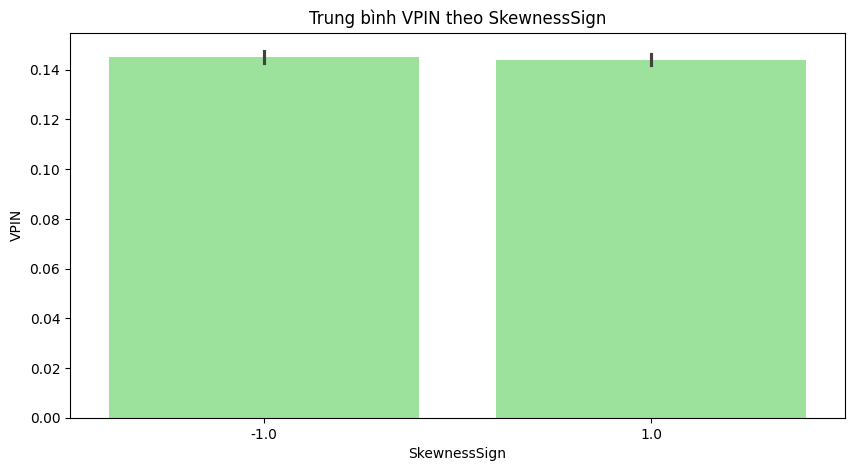

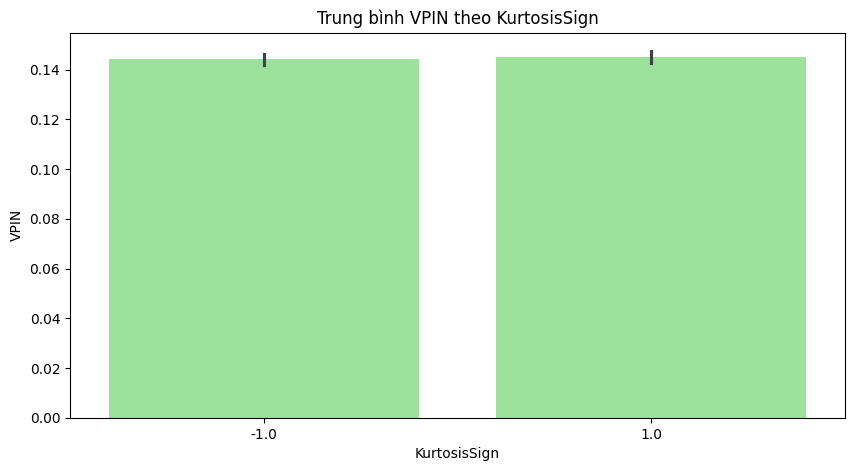

In [22]:
for col in target_cols:
    plt.figure(figsize=(10, 5))
    sns.barplot(x=col, y='VPIN', data=df, color='lightgreen', errorbar=('ci', 95))
    plt.title(f'Trung bình VPIN theo {col}')
    plt.show()

# Kiểm định

### Kiểm tra phân phối của dữ liệu VPIN

- Giả thuyết H0: Dữ liệu VPIN tuân theo phân phối chuẩn
- Giả thuyết H1: Dữ liệu không tuân theo phân phối chuẩn.

In [23]:
stat, p = shapiro(df['VPIN'].dropna())
print(f'Shapiro-Wilk test: p-value = {p}')


Shapiro-Wilk test: p-value = 1.1625397211910504e-21


In [24]:
stat, p = shapiro(np.log(df['VPIN'].dropna()))
p

np.float64(1.019276609696751e-16)

- p rất bé => Bác bỏ giả thuyết H0. Chưa đủ bằng chứng để kết luận rằng VPIN có phân phối chuẩn

### Kiểm tra phân phối của VPIN theo từng nhóm

- Giả thuyết H0: VPIN cho từng nhóm có phân phối chuẩn
- Giả thuyế H1: VPIN cho từng nhóm không có phân phối chuẩn

In [25]:
for col in target_cols:
    print(f"Kiểm định cho giá trị {col}")
    gr1 = df.loc[df[col] == 1, "VPIN"]
    p1 = shapiro(gr1)[1]
    gr2 = df.loc[df[col] == -1, "VPIN"]
    p2 = shapiro(gr1)[1]
    print(f"pvalue với {col} = 1 cho VPIN: ", p1)
    print(f"pvalue với {col} = -1 cho VPIN: ", p2)

Kiểm định cho giá trị SpreadChangeSign
pvalue với SpreadChangeSign = 1 cho VPIN:  8.617621745488085e-16
pvalue với SpreadChangeSign = -1 cho VPIN:  8.617621745488085e-16
Kiểm định cho giá trị RealizedVolatilitySign
pvalue với RealizedVolatilitySign = 1 cho VPIN:  1.7113797362690274e-15
pvalue với RealizedVolatilitySign = -1 cho VPIN:  1.7113797362690274e-15
Kiểm định cho giá trị JB_ChangeSign
pvalue với JB_ChangeSign = 1 cho VPIN:  2.8927021671343277e-15
pvalue với JB_ChangeSign = -1 cho VPIN:  2.8927021671343277e-15
Kiểm định cho giá trị AR_ChangeSign
pvalue với AR_ChangeSign = 1 cho VPIN:  2.073412776991672e-16
pvalue với AR_ChangeSign = -1 cho VPIN:  2.073412776991672e-16
Kiểm định cho giá trị SkewnessSign
pvalue với SkewnessSign = 1 cho VPIN:  8.294208207801129e-14
pvalue với SkewnessSign = -1 cho VPIN:  8.294208207801129e-14
Kiểm định cho giá trị KurtosisSign
pvalue với KurtosisSign = 1 cho VPIN:  7.445838259157361e-15
pvalue với KurtosisSign = -1 cho VPIN:  7.445838259157361e-15


- Bác bỏ giả thuyết H0 rằng VPIN cho từng nhóm có phân phối chuẩn

- Dữ liệu VPIN và dữ liệu VPIN theo từng nhóm đều không có phân phối chuẩn, ta dùng kiểm định mannwhitneyu để kiểm định xem  giá trị VPIN có khác biệt giữa các nhóm phân loại hay không

In [26]:
for col in target_cols:
    print(f"Kiểm định cho giá trị {col}")
    gr1 = df.loc[df[col] == 1, "VPIN"]
    gr2 = df.loc[df[col] == -1, "VPIN"]
    stat, p = mannwhitneyu(gr1, gr2)
    print(f"pvalue Mann-Whitney U Test cột {col} : ", p)

Kiểm định cho giá trị SpreadChangeSign
pvalue Mann-Whitney U Test cột SpreadChangeSign :  0.5790070290306167
Kiểm định cho giá trị RealizedVolatilitySign
pvalue Mann-Whitney U Test cột RealizedVolatilitySign :  0.34067361220495906
Kiểm định cho giá trị JB_ChangeSign
pvalue Mann-Whitney U Test cột JB_ChangeSign :  0.870886817803391
Kiểm định cho giá trị AR_ChangeSign
pvalue Mann-Whitney U Test cột AR_ChangeSign :  0.3045436618420735
Kiểm định cho giá trị SkewnessSign
pvalue Mann-Whitney U Test cột SkewnessSign :  0.713544836677479
Kiểm định cho giá trị KurtosisSign
pvalue Mann-Whitney U Test cột KurtosisSign :  0.937960411343597


- p-value ≥ 0.05 → Không có bằng chứng thống kê cho thấy sự khác biệt giữa các nhóm.

## Áp dụng model: RandomForest

### Chuẩn bị bộ dữ liệu

In [27]:
for col in target_cols:
    print(pd.DataFrame(df[col].value_counts()))

                  count
SpreadChangeSign       
-1.0                293
 1.0                293
                        count
RealizedVolatilitySign       
-1.0                      296
 1.0                      290
               count
JB_ChangeSign       
 1.0             299
-1.0             287
               count
AR_ChangeSign       
 1.0             295
-1.0             291
              count
SkewnessSign       
-1.0            301
 1.0            285
              count
KurtosisSign       
-1.0            294
 1.0            292


- Bộ dữ liệu có sự phân bố nhãn khá cân bằng giữa hai chiều giá trị (-1.0 và 1.0) ở các biến mục tiê. Mỗi biến đều có số lượng mẫu gần như tương đương giữa hai nhãn, với chênh lệch không đáng kể (dao động trong khoảng 2–14 mẫu). Điều này cho thấy bộ dữ liệu phù hợp để huấn luyện các mô hình học máy mà không cần xử lý mất cân bằng nhãn quá phức tạp.

In [28]:
train_data, test_data = {}, {}
for col in target_cols:
    data = df.copy()
    train_data[col], test_data[col] = train_test_split(data, test_size=0.3, random_state=42, stratify=data[col])
    

In [29]:
train_cols = ["VPIN"]
model_info = {}
for col in target_cols:
    X_train = train_data[col][["VPIN", "Price"]]
    y_train = train_data[col][col]
    X_test = test_data[col][["VPIN", "Price"]]
    y_test = test_data[col][col]

    model_info[col] = RandomForestClassifier(n_estimators=1000, random_state=42)

    model_info[col].fit(X_train, y_train)

    y_pred = model_info[col].predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, output_dict=True)

    print(f"Độ chính xác của mô hình cho {col}: {accuracy:.4f}")
    print(classification_report(y_test, y_pred))

Độ chính xác của mô hình cho SpreadChangeSign: 0.4091
              precision    recall  f1-score   support

        -1.0       0.41      0.43      0.42        88
         1.0       0.40      0.39      0.40        88

    accuracy                           0.41       176
   macro avg       0.41      0.41      0.41       176
weighted avg       0.41      0.41      0.41       176

Độ chính xác của mô hình cho RealizedVolatilitySign: 0.5625
              precision    recall  f1-score   support

        -1.0       0.57      0.53      0.55        89
         1.0       0.55      0.60      0.57        87

    accuracy                           0.56       176
   macro avg       0.56      0.56      0.56       176
weighted avg       0.56      0.56      0.56       176

Độ chính xác của mô hình cho JB_ChangeSign: 0.4886
              precision    recall  f1-score   support

        -1.0       0.48      0.49      0.48        86
         1.0       0.50      0.49      0.49        90

    accuracy     

### DÙng nhiều biến đầu vào hơn

In [34]:
train_cols = ["Price", "VPIN", "BidPrice", "AskPrice"]
model_info = {}
for col in target_cols:
    X_train = train_data[col][train_cols]
    y_train = train_data[col][col]
    X_test = test_data[col][train_cols]
    y_test = test_data[col][col]

    model_info[col] = RandomForestClassifier(n_estimators=10000, random_state=42)

    model_info[col].fit(X_train, y_train)

    y_pred = model_info[col].predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, output_dict=True)

    print(f"Độ chính xác của mô hình cho {col}: {accuracy:.4f}")
    print(classification_report(y_test, y_pred))

Độ chính xác của mô hình cho SpreadChangeSign: 0.4261
              precision    recall  f1-score   support

        -1.0       0.43      0.43      0.43        88
         1.0       0.43      0.42      0.42        88

    accuracy                           0.43       176
   macro avg       0.43      0.43      0.43       176
weighted avg       0.43      0.43      0.43       176

Độ chính xác của mô hình cho RealizedVolatilitySign: 0.5511
              precision    recall  f1-score   support

        -1.0       0.56      0.52      0.54        89
         1.0       0.54      0.59      0.56        87

    accuracy                           0.55       176
   macro avg       0.55      0.55      0.55       176
weighted avg       0.55      0.55      0.55       176

Độ chính xác của mô hình cho JB_ChangeSign: 0.4489
              precision    recall  f1-score   support

        -1.0       0.44      0.45      0.45        86
         1.0       0.46      0.44      0.45        90

    accuracy     

### Mô hình XGBoost

In [31]:

# Khởi tạo mô hình XGBoost
model = XGBClassifier(
    n_estimators=100,
    max_depth=3,
    learning_rate=0.1,
    # use_label_encoder=False,
    eval_metric='logloss'
)

In [32]:
train_cols = ["VPIN"]
for col in target_cols:
    X_train = train_data[col][train_cols]
    y_train = train_data[col][col].map({-1.0: 0, 1.0: 1})
    X_test = test_data[col][train_cols]
    y_test = test_data[col][col].map({-1.0: 0, 1.0: 1})

    # Huấn luyện mô hình
    model.fit(X_train, y_train)

    # Dự đoán và đánh giá
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred)

    print(f"Độ chính xác của mô hình: {accuracy:.4f}")
    print("Báo cáo phân loại:")
    print(report)


Độ chính xác của mô hình: 0.4205
Báo cáo phân loại:
              precision    recall  f1-score   support

           0       0.43      0.49      0.46        88
           1       0.41      0.35      0.38        88

    accuracy                           0.42       176
   macro avg       0.42      0.42      0.42       176
weighted avg       0.42      0.42      0.42       176

Độ chính xác của mô hình: 0.5227
Báo cáo phân loại:
              precision    recall  f1-score   support

           0       0.53      0.47      0.50        89
           1       0.52      0.57      0.54        87

    accuracy                           0.52       176
   macro avg       0.52      0.52      0.52       176
weighted avg       0.52      0.52      0.52       176

Độ chính xác của mô hình: 0.5227
Báo cáo phân loại:
              precision    recall  f1-score   support

           0       0.52      0.40      0.45        86
           1       0.53      0.64      0.58        90

    accuracy              

In [33]:
train_cols = ["Price", "VPIN", "BidPrice", "AskPrice"]
for col in target_cols:
    X_train = train_data[col][train_cols]
    y_train = train_data[col][col].map({-1.0: 0, 1.0: 1})
    X_test = test_data[col][train_cols]
    y_test = test_data[col][col].map({-1.0: 0, 1.0: 1})

    # Huấn luyện mô hình
    model.fit(X_train, y_train)

    # Dự đoán và đánh giá
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred)

    print(f"Độ chính xác của mô hình: {accuracy:.4f}")
    print("Báo cáo phân loại:")
    print(report)


Độ chính xác của mô hình: 0.5057
Báo cáo phân loại:
              precision    recall  f1-score   support

           0       0.51      0.50      0.50        88
           1       0.51      0.51      0.51        88

    accuracy                           0.51       176
   macro avg       0.51      0.51      0.51       176
weighted avg       0.51      0.51      0.51       176

Độ chính xác của mô hình: 0.5568
Báo cáo phân loại:
              precision    recall  f1-score   support

           0       0.56      0.55      0.56        89
           1       0.55      0.56      0.56        87

    accuracy                           0.56       176
   macro avg       0.56      0.56      0.56       176
weighted avg       0.56      0.56      0.56       176

Độ chính xác của mô hình: 0.4886
Báo cáo phân loại:
              precision    recall  f1-score   support

           0       0.48      0.45      0.46        86
           1       0.50      0.52      0.51        90

    accuracy              